# K Nearest Neighbors

Author: Luke Moraglia

This notebook gives an overview of the K nearest neighbors algorithm and implements a `KNeighborsClassifier` from `scikit-learn`.

## Main idea
K nearest neighbors (KNN) is probably one of the easier to understand classification algorithms. The algorithm classifies an observation based on the classes of the $k$ observations closest to it, where $k$ is an integer greater than zero. The observation is assigned the class that has the most "votes" among the $k$ nearest neighbors. The value of $k$ is set by the user, and the observations that are considered "closest" are determined by the distances between the observation being classified and all the other training observations. In general, any distance can be used, though the Euclidean distance is the most common.

## Both classification and regression
The KNN algorithm is most often explained for classification, as in the paragraph above, but it can also be used for regression. Instead of being assigned to a class, an observation is assigned the average value of the output variable of its $k$ nearest neighbors. 

Additionally, neighbors can be weighted so that some have greater importance than others. A common method is to give weights of $1 / d$ where $d$ is the distance from the neighbor to the observation, so that as the distance to a neighbor increases, the weight of that neighbor decreases. 

## (Re)Sources

- [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
- [Statquest](https://youtu.be/HVXime0nQeI)
- [sklearn](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)
- [ISLR](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf) ch 2, pg 39

# Library Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from helpers import cust_func

%matplotlib inline
#plt.rcParams['figure.figsize'] = [16, 9]
plt.style.use("fivethirtyeight")
%load_ext autoreload
%autoreload 2

# Load Data
As an easy example, we'll use the ubiquitous iris dataset. Four continuous features of irises are used to predict one of three species. The data come easily availabe from `sklearn`.

In [2]:
iris = datasets.load_iris(as_frame=True)

In [3]:
X, y = iris.data, iris.target

## Train Test Split
We split the data, and then sort them by the species (this is needed to make visuals easier later on).

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y)

In [5]:
y_train, y_test = y_train.sort_values(), y_test.sort_values()
X_train, X_test = X_train.loc[y_train.index], X_test.loc[y_test.index]

# Dimension Reduction with PCA
We have four predictor variables in X, but we are going to reduce them down to two components. As we will see, we can capture nearly all of the variance in the data just with the first two components. We'll create the PCA components using only the training data, and project our testing data on to these components afterward.

In [6]:
pca_out = PCA(n_components=2).fit(X_train)

In [7]:
# Percentage of variance explained by the first two components
round(sum(pca_out.explained_variance_ratio_), 2)

0.98

In [8]:
# Factor scores (i.e., components)
fscores = pca_out.transform(X_train)
fscores_test = pca_out.transform(X_test)

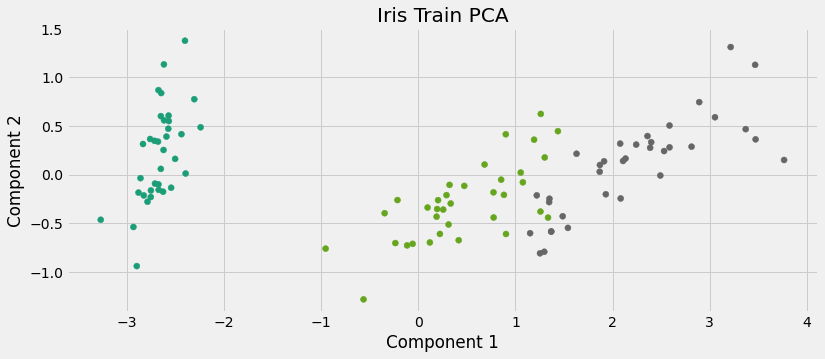

In [9]:
# Plot fscores for first two components
plt.figure(figsize=(12, 12))
sc = plt.scatter(fscores[:, 0], fscores[:, 1],
                 c=y_train, cmap=plt.cm.get_cmap('Dark2', 3))
ax = sc.axes
ax.set_aspect('equal')
plt.title("Iris Train PCA")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

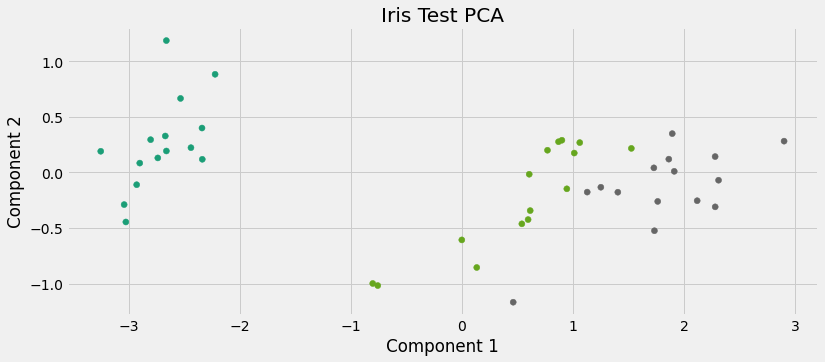

In [10]:
# Plot fscores_test for first two components
plt.figure(figsize=(12, 12))
sc = plt.scatter(fscores_test[:, 0], fscores_test[:, 1],
                 c=y_test, cmap=plt.cm.get_cmap('Dark2', 3))
ax = sc.axes
ax.set_aspect('equal')
plt.title("Iris Test PCA")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

The test data creates similar groupings as the training data on the first two components.

# Fit `KNeighborsClassifier`
We'll use the PCA training factor scores as our two predictors of species. The `KNeighborsClassifier` simply stores these training data. When a new observation is classified using the `score` method, the classifier checks the class of the $k$ nearest neighbors and assigns the new observation to the most frequent class.

In [11]:
# default for n_neighbors is 5
n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(fscores, y_train) 

KNeighborsClassifier()

In [12]:
# Accuracy scores
train_score = knn.score(fscores, y_train)
test_score = knn.score(fscores_test, y_test)
print(f"Train score: {round(train_score, 3)}")
print(f"Test score: {round(test_score, 3)}")

Train score: 0.981
Test score: 0.956


Our accuracy is very high, but this isn't much of a surprise based on the earlier plots. The 3 classes are fairly distinct.

# Classification visualizations
We plot the observations, colored with their true class. The colors shaded behind them indicate the predicted class of observations within the shaded region.

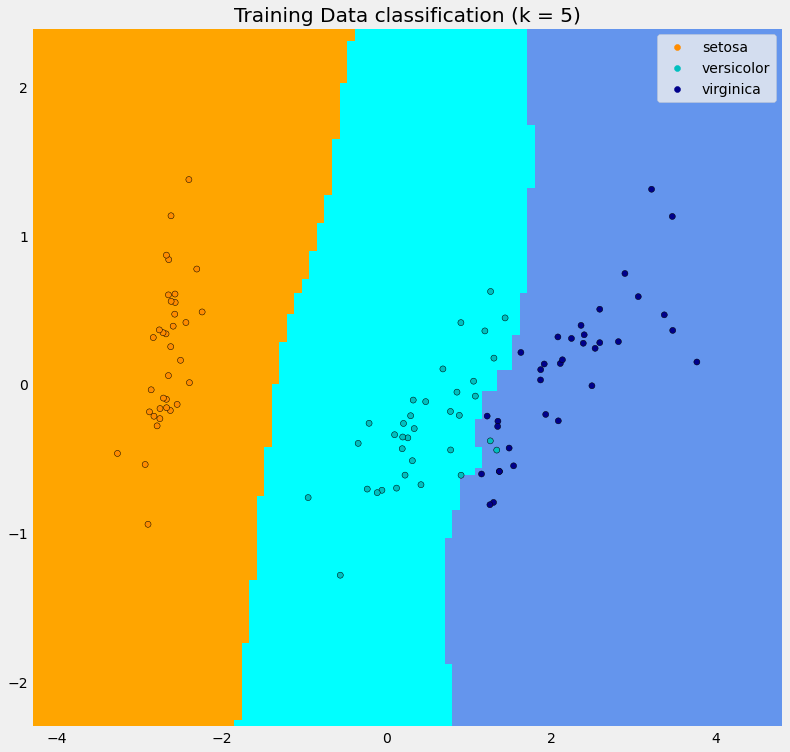

In [13]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

fig, ax = plt.subplots(figsize=(12, 12))
DecisionBoundaryDisplay.from_estimator(
    knn,
    fscores,
    cmap=cmap_light,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    #xlabel=iris.feature_names[0],
    #ylabel=iris.feature_names[1],
    shading="auto",
)

# Plot also the training points
sns.scatterplot(
    x=fscores[:,0],
    y=fscores[:,1],
    hue=iris.target_names[y_train],
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.title(
    "Training Data classification (k = %i)" % (n_neighbors)
)
plt.show()

All setosa and virginica were classified correctly, but some versicolor were classified as virginica.

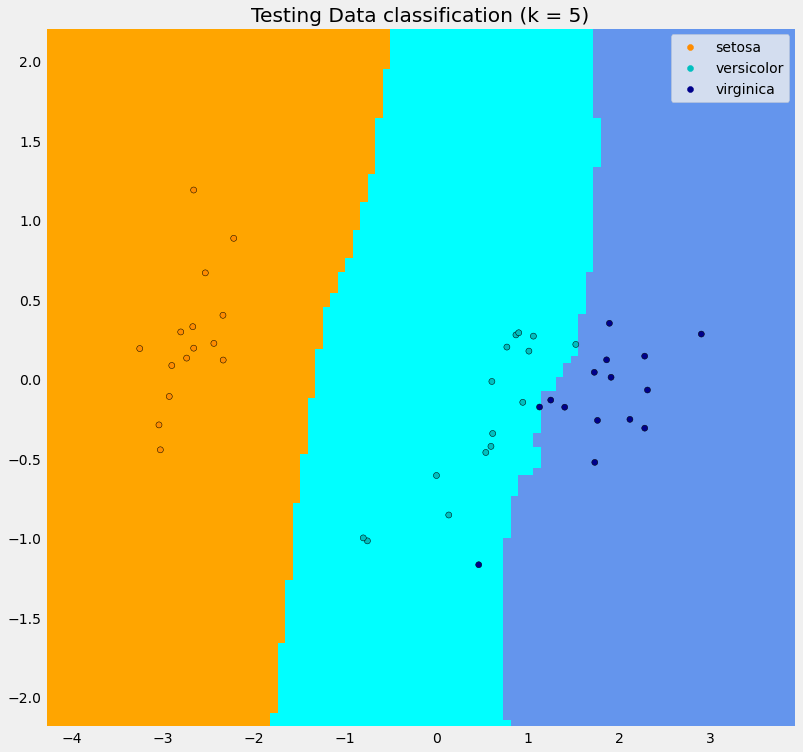

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
DecisionBoundaryDisplay.from_estimator(
    knn,
    fscores_test,
    cmap=cmap_light,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    #xlabel=iris.feature_names[0],
    #ylabel=iris.feature_names[1],
    shading="auto",
)

# Plot also the test points
sns.scatterplot(
    x=fscores_test[:,0],
    y=fscores_test[:,1],
    hue=iris.target_names[y_test],
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.title(
    "Testing Data classification (k = %i)" % (n_neighbors)
)
plt.show()

In the testing data, all setosa were once again classified correctly, but now some virginica were classified as versicolor.

# Confusion Matrices

In [15]:
true_labels = ["True " + species for species in iris.target_names]
pred_labels = ["Pred " + species for species in iris.target_names]
#dict(enumerate("True " + str(iris.target_names)))

In [16]:
cm = cust_func.nice_conf_mat(y_train,
                             knn.predict(fscores),
                             row_dict = dict(enumerate(true_labels)),
                             column_dict = dict(enumerate(pred_labels)))

,Pred setosa,Pred versicolor,Pred virginica
True setosa,35,0,0
True versicolor,0,33,2
True virginica,0,0,35


In [17]:
cm = cust_func.nice_conf_mat(y_test,
                             knn.predict(fscores_test),
                             row_dict = dict(enumerate(true_labels)),
                             column_dict = dict(enumerate(pred_labels)))

,Pred setosa,Pred versicolor,Pred virginica
True setosa,15,0,0
True versicolor,0,15,0
True virginica,0,2,13
